### Cost of risk based on the European Central Bank DWH

Cost of risk is the ratio of the adjustments in allowances for estimated loan losses during the relevant period (annualised) divided by the total amount of loans and advances subject to impairment.

Please note that you can change the assumptions about lag between GDP and Cost of Risk as well as the COVID period in the code. The results are quite sensitive to this option.

See also:
- [Introduction to the ECB DWH](https://sdw-wsrest.ecb.europa.eu/help/)
- [Available data series](https://sdw.ecb.europa.eu/browseSelection.do?node=9698058)


In [1]:
import io
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandasdmx as sdmx
import requests
from sklearn.linear_model import HuberRegressor
from scipy.stats import pearsonr

# Options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

### A. Helper functions

In [2]:
def sup_ecb_data(countries, data_items, report_type="estimates"):
    # Query the ECB DWH for risk data

    country_list = "+".join(countries)
    item_list = "+".join(data_items)

    entrypoint = "https://sdw-wsrest.ecb.europa.eu/service/"
    resource = "data"
    flowRef = "SUP"

    if report_type == "estimates":
        key = f"Q.B01.{country_list}._Z.{item_list}._T._Z._Z._Z._Z.PCT.C"
    elif report_type == "risk_weights":
        key = f"Q.{country_list}.W0._Z.{item_list}._T._Z._Z._Z._Z.PCT.C"
    elif report_type == "cost_of_risk":
        key = f"Q.{country_list}.W0._Z.{item_list}._T.SII._Z._Z._Z.PCT.C"
    elif report_type == "gdp":
        flowRef = "MNA"
        key = f"Q.Y.{country_list}.W2.S1.S1.B.{item_list}._Z._Z._Z.XDC.LR.GY"

    # Define the parameters
    params = {
        "startPeriod": "2000-01-01",  # Start date of the time series
        "endPeriod": "2024-06-30",  # End of the time series
    }

    # Create the query
    request_url = entrypoint + resource + "/" + flowRef + "/" + key

    print(request_url)

    # Make the HTTP request
    response = requests.get(request_url, params=params, headers={"Accept": "text/csv"})

    return pd.read_csv(io.StringIO(response.text))

### B. View available time series

In [3]:
# Source: https://sdw.ecb.europa.eu/datastructure.do?conceptMnemonic=CB_ITEM&datasetinstanceid=359#cl
data_catalogue = pd.read_csv("ecb_dwh_data_catalogue.csv", sep="\t", encoding="utf-8")
data_catalogue.head()

,Unnamed: 0,Label,Key,From,To,Last Updated,Frequency,Country,Item,Country.1,Data type,Balance sheet suffix,Long description
0,0,TOTAL RISK EXPOSURE AMOUNT / TOTAL EXPOSURES,SUP.Q.AT.W0._Z.E0000._T._Z._Z.ALL.LE.E.C,2015Q2,2022Q3,2023-01-11 10:00:00,Q,AT,E0000,ALL,LE,E,"Austria, World (all entities, including refer..."
1,1,"TOTAL EXPOSURES FOR CREDIT, COUNTERPARTY CREDI...",SUP.Q.AT.W0._Z.E1000._T._Z._Z.ALL.LE.E.C,2015Q2,2022Q3,2023-01-11 10:00:00,Q,AT,E1000,ALL,LE,E,"Austria, World (all entities, including refer..."
2,2,Exposures to credit risk - Risk exposure amoun...,SUP.Q.AT.W0._Z.E1100._T._Z._Z.ALL.LE.E.C,2015Q2,2022Q3,2023-01-11 10:00:00,Q,AT,E1100,ALL,LE,E,"Austria, World (all entities, including refer..."
3,3,Securitisation positions,SUP.Q.AT.W0._Z.E1300._T._Z._Z.ALL.LE.E.C,2020Q1,2022Q3,2023-01-11 10:00:00,Q,AT,E1300,ALL,LE,E,"Austria, World (all entities, including refer..."
4,4,Exposures to credit risk - Standardised approa...,SUP.Q.AT.W0._Z.E2000._T._Z._Z.ALL.LE.E.C,2015Q2,2022Q3,2023-01-11 10:00:00,Q,AT,E2000,ALL,LE,E,"Austria, World (all entities, including refer..."


### C. Get Risk Cost and GDP data

In [4]:
# Get PD and LGD data
countries = ["ES", "DE", "FR", "IT", "SE", "IT", "NL", "CH", "BE"]

# Request for Cost of Risk
data_items = ["I2110"]
risk_cost_df = sup_ecb_data(countries, data_items, report_type="cost_of_risk")
risk_cost_df["TIME_PERIOD_ADJ"] = risk_cost_df["TIME_PERIOD"].apply(
    lambda x: pd.Period(x, freq="Q").end_time.normalize()
)
risk_cost_df = risk_cost_df[
    ["TIME_PERIOD", "TIME_PERIOD_ADJ", "TITLE", "REF_AREA", "OBS_VALUE"]
]
risk_cost_df = risk_cost_df.dropna()

# Request for GDP (# https://data.ecb.europa.eu/data/datasets/MNA/MNA.Q.Y.I9.W2.S1.S1.B.B1GQ._Z._Z._Z.EUR.LR.GY)
data_items = ["B1GQ"]
gdp_df = sup_ecb_data(countries, data_items, report_type="gdp")
gdp_df["TIME_PERIOD_ADJ"] = gdp_df["TIME_PERIOD"].apply(
    lambda x: pd.Period(x, freq="Q").end_time.normalize()
)
gdp_df = gdp_df[["TIME_PERIOD", "TIME_PERIOD_ADJ", "TITLE", "REF_AREA", "OBS_VALUE"]]
gdp_df = gdp_df.dropna()

https://sdw-wsrest.ecb.europa.eu/service/data/SUP/Q.ES+DE+FR+IT+SE+IT+NL+CH+BE.W0._Z.I2110._T.SII._Z._Z._Z.PCT.C
https://sdw-wsrest.ecb.europa.eu/service/data/MNA/Q.Y.ES+DE+FR+IT+SE+IT+NL+CH+BE.W2.S1.S1.B.B1GQ._Z._Z._Z.XDC.LR.GY


In [5]:
# Review data quality of the resulting dataframe
risk_cost_df.pivot_table(values='OBS_VALUE', index='TIME_PERIOD_ADJ', columns='REF_AREA', aggfunc='count')

REF_AREA,BE,DE,ES,FR,IT,NL
TIME_PERIOD_ADJ,,,,,,
2019-03-31,1.0,1.0,1.0,1.0,1.0,1.0
2019-06-30,1.0,1.0,1.0,1.0,1.0,1.0
2019-09-30,1.0,1.0,1.0,1.0,1.0,1.0
2019-12-31,1.0,1.0,1.0,1.0,1.0,1.0
2020-03-31,1.0,1.0,1.0,1.0,1.0,1.0
2020-06-30,1.0,1.0,1.0,1.0,1.0,1.0
2020-09-30,1.0,1.0,1.0,1.0,1.0,1.0
2020-12-31,1.0,1.0,1.0,1.0,1.0,1.0
2021-03-31,NaN,1.0,1.0,1.0,1.0,1.0


In [6]:
# Review data quality of the resulting dataframe
gdp_df.pivot_table(values='OBS_VALUE', index='TIME_PERIOD_ADJ', columns='REF_AREA', aggfunc='count')

REF_AREA,BE,DE,ES,FR,IT,NL,SE
TIME_PERIOD_ADJ,,,,,,,
2000-03-31,1,1,1,1,1,1,1
2000-06-30,1,1,1,1,1,1,1
2000-09-30,1,1,1,1,1,1,1
2000-12-31,1,1,1,1,1,1,1
2001-03-31,1,1,1,1,1,1,1
2001-06-30,1,1,1,1,1,1,1
2001-09-30,1,1,1,1,1,1,1
2001-12-31,1,1,1,1,1,1,1
2002-03-31,1,1,1,1,1,1,1


#### D. Create the analysis dataset

In [7]:
# Determine covid years
covid_start = 2020
covid_end = 2021
n_quarters_lag = 0
start_year = 2015

In [8]:
# Number of quarters to add
gdp_df['TIME_PERIOD_OFFSET'] = gdp_df['TIME_PERIOD_ADJ'] + pd.offsets.QuarterEnd(n=n_quarters_lag)

# Filter the required period
risk_cost_df = risk_cost_df[risk_cost_df['TIME_PERIOD_ADJ'].dt.year >= start_year]

# View results
gdp_df.sample(5)

,TIME_PERIOD,TIME_PERIOD_ADJ,TITLE,REF_AREA,OBS_VALUE,TIME_PERIOD_OFFSET
307,2004-Q1,2004-03-31,Gross domestic product at market prices,FR,2.041323,2003-09-30
353,2015-Q3,2015-09-30,Gross domestic product at market prices,FR,0.694624,2015-03-31
143,2011-Q3,2011-09-30,Gross domestic product at market prices,DE,3.765807,2011-03-31
168,2017-Q4,2017-12-31,Gross domestic product at market prices,DE,3.753542,2017-06-30
497,2003-Q1,2003-03-31,Gross domestic product at market prices,NL,0.671931,2002-09-30


In [9]:
# Merge
analysis_df = risk_cost_df.merge(
    gdp_df[["TIME_PERIOD_OFFSET", "TITLE", "REF_AREA", "OBS_VALUE"]],
    how="left",
    left_on=["TIME_PERIOD_ADJ", "REF_AREA"],
    right_on=["TIME_PERIOD_OFFSET", "REF_AREA"],
)

analysis_df = analysis_df.drop(columns=['TIME_PERIOD_OFFSET'])
analysis_df = analysis_df.dropna()

analysis_df.columns = [
    "TIME_PERIOD",
    "TIME_PERIOD_ADJ",
    "TITLE_OBS_VALUE_1",
    "REF_AREA",
    "OBS_VALUE_1",
    "TITLE_OBS_VALUE_2",
    "OBS_VALUE_2",
]

analysis_df.head()

,TIME_PERIOD,TIME_PERIOD_ADJ,TITLE_OBS_VALUE_1,REF_AREA,OBS_VALUE_1,TITLE_OBS_VALUE_2,OBS_VALUE_2
0,2019-Q1,2019-03-31,"Cost of risk, SIs",BE,0.20,Gross domestic product at market prices,2.534938
1,2019-Q2,2019-06-30,"Cost of risk, SIs",BE,0.19,Gross domestic product at market prices,2.146725
2,2019-Q3,2019-09-30,"Cost of risk, SIs",BE,0.17,Gross domestic product at market prices,-1.021267
3,2019-Q4,2019-12-31,"Cost of risk, SIs",BE,0.18,Gross domestic product at market prices,-12.780487
4,2020-Q1,2020-03-31,"Cost of risk, SIs",BE,0.25,Gross domestic product at market prices,-3.241278


In [10]:
# Review data quality of the resulting dataframe
analysis_df.pivot_table(values='OBS_VALUE_1', index='TIME_PERIOD_ADJ', columns='REF_AREA', aggfunc='count')

REF_AREA,BE,DE,ES,FR,IT,NL
TIME_PERIOD_ADJ,,,,,,
2019-03-31,1.0,1.0,1.0,1.0,1.0,1.0
2019-06-30,1.0,1.0,1.0,1.0,1.0,1.0
2019-09-30,1.0,1.0,1.0,1.0,1.0,1.0
2019-12-31,1.0,1.0,1.0,1.0,1.0,1.0
2020-03-31,1.0,1.0,1.0,1.0,1.0,1.0
2020-06-30,1.0,1.0,1.0,1.0,1.0,1.0
2020-09-30,1.0,1.0,1.0,1.0,1.0,1.0
2020-12-31,1.0,1.0,1.0,1.0,1.0,1.0
2021-03-31,NaN,1.0,1.0,1.0,1.0,1.0


In [11]:
# Filter the required period
averages_df = analysis_df.copy()
idx_1 = averages_df['TIME_PERIOD_ADJ'].dt.year < covid_start
idx_2 = averages_df['TIME_PERIOD_ADJ'].dt.year > covid_end
averages_df = averages_df[idx_1 | idx_2]

# Deduct average risk cost per country
country_means = (
    averages_df.groupby("REF_AREA")[["OBS_VALUE_1"]].mean().reset_index()
)
country_means.columns = ['REF_AREA', 'AVERAGE_RISK_COST']
analysis_df = pd.merge(analysis_df, country_means, on="REF_AREA")
analysis_df['RISK_COST_ADJ'] =  analysis_df['OBS_VALUE_1'] - analysis_df['AVERAGE_RISK_COST']

# Create df for plotting
plot_df = analysis_df[['TIME_PERIOD_ADJ', 'REF_AREA', 'RISK_COST_ADJ', 'OBS_VALUE_2']].copy()
plot_df.columns = ['TIME_PERIOD_ADJ', 'REF_AREA', 'Cost of risk', 'Change in GDP']

# View results
analysis_df.sample(5)

,TIME_PERIOD,TIME_PERIOD_ADJ,TITLE_OBS_VALUE_1,REF_AREA,OBS_VALUE_1,TITLE_OBS_VALUE_2,OBS_VALUE_2,AVERAGE_RISK_COST,RISK_COST_ADJ
56,2019-Q1,2019-03-31,"Cost of risk, SIs",FR,0.54,Gross domestic product at market prices,2.219157,0.443636,0.096364
84,2021-Q2,2021-06-30,"Cost of risk, SIs",IT,0.59,Gross domestic product at market prices,8.044776,0.709091,-0.119091
75,2019-Q1,2019-03-31,"Cost of risk, SIs",IT,2.05,Gross domestic product at market prices,0.780095,0.709091,1.340909
61,2020-Q2,2020-06-30,"Cost of risk, SIs",FR,0.60,Gross domestic product at market prices,-3.757506,0.443636,0.156364
66,2021-Q3,2021-09-30,"Cost of risk, SIs",FR,0.43,Gross domestic product at market prices,4.746800,0.443636,-0.013636


#### D. Create plots

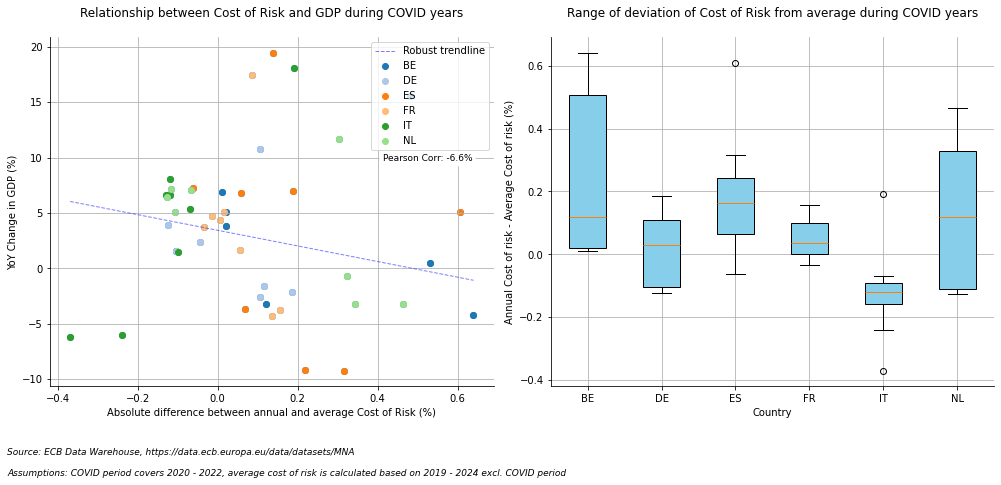

In [12]:
# Filter the required period
plot_df = plot_df[plot_df['TIME_PERIOD_ADJ'].dt.year >= covid_start]
plot_df = plot_df[plot_df['TIME_PERIOD_ADJ'].dt.year <= covid_end]

# Calculate the Pearson correlation coefficient
corr_coef, _ = pearsonr(plot_df["Cost of risk"], plot_df["Change in GDP"])

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot for the first graph (left subplot)
ax1.scatter(plot_df["Cost of risk"], plot_df["Change in GDP"])

# Prepare the data
X = plot_df["Cost of risk"].values.reshape(-1, 1)
y = plot_df["Change in GDP"].values

# Fit the Huber regressor
huber = HuberRegressor()
huber.fit(X, y)

# Predict the trendline
line_X = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
line_y_huber = huber.predict(line_X)

# Plot the trendline
ax1.plot(
    line_X,
    line_y_huber,
    "b--",
    label="Robust trendline",
    linewidth=1,
    alpha=0.5,
)

ax1.set_xlabel("Absolute difference between annual and average Cost of Risk (%)")
ax1.set_ylabel("YoY Change in GDP (%)")
ax1.set_title("Relationship between Cost of Risk and GDP during COVID years", pad=20)
ax1.grid(True)

# Create a color map for each unique country
unique_countries = plot_df['REF_AREA'].unique()
colors = plt.colormaps['tab20'].colors
color_map = {country: colors[i % len(colors)] for i, country in enumerate(unique_countries)}


# Plot each row with the appropriate color
for i, row in plot_df.iterrows():
    ax1.scatter(
        row["Cost of risk"],
        row["Change in GDP"],
        color=color_map[row["REF_AREA"]],
        label=row["REF_AREA"]
    )

# Create a custom legend to show only one entry per country
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), loc='upper right')


# Annotate the correlation coefficient
ax1.text(
    0.75, 0.665, f"Pearson Corr: {corr_coef:.1%}",
    transform=ax1.transAxes,
    fontsize=9,
    verticalalignment='top',
    bbox=dict(boxstyle='round, pad=0.3', edgecolor='white', facecolor='white'),
    # bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
)

# Remove the top and right borderlines for the first graph
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# Plot for the second graph (right subplot)
data_by_area = [plot_df[plot_df['REF_AREA'] == area]['Cost of risk'] for area in plot_df['REF_AREA'].unique()]
ax2.boxplot(data_by_area, patch_artist=True, boxprops=dict(facecolor='skyblue'))

ax2.set_xticklabels(plot_df['REF_AREA'].unique(), ha='center')
ax2.set_xlabel("Country")
ax2.set_ylabel("Annual Cost of risk - Average Cost of risk (%)")
ax2.set_title("Range of deviation of Cost of Risk from average during COVID years", pad=20)
ax2.grid(True)

# Remove the top and right borderlines for the second graph
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a footnote with the source (for both subplots)
fig.text(
    0.01,
    -0.11,
    "Source: ECB Data Warehouse, https://data.ecb.europa.eu/data/datasets/MNA" + 
    "\n\nAssumptions: COVID period covers 2020 - 2022, average cost of risk is calculated based on 2019 - 2024 excl. COVID period",
    ha="left",
    fontsize=9,
    style="italic",
)

# Save the plot to a file
plt.savefig('cost_of_risk_vs_change_in_gdp.png', dpi=300)

plt.show()